In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import hypernetx as hnx

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central
import core_utils

/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/xgi/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
num_core_nodes = 4
num_periphery_nodes = 10
edge_probability_core = 0.95
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.1

CP = core_utils.generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

core_nodes, periphery_nodes, edges, incidence_matrix = CP

H = pd.DataFrame(incidence_matrix)
H = H.sample(frac=1, axis=1) 
print(f"{H.shape=}")
print(f"Min Order: {np.min(H.sum(axis=0))}")
H

H.shape=(14, 8)
Min Order: 2


,7,4,2,6,1,3,0,5
0,0,1,1,0,1,0,0,0
1,1,0,0,0,1,0,1,0
2,0,0,1,1,0,0,1,1
3,0,0,1,0,1,0,1,0
4,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0
8,0,0,0,1,0,1,0,0
9,0,0,0,0,0,0,0,1


# Plot the Hypergraphs

/home/cstansbu/miniconda3/envs/higher_order/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


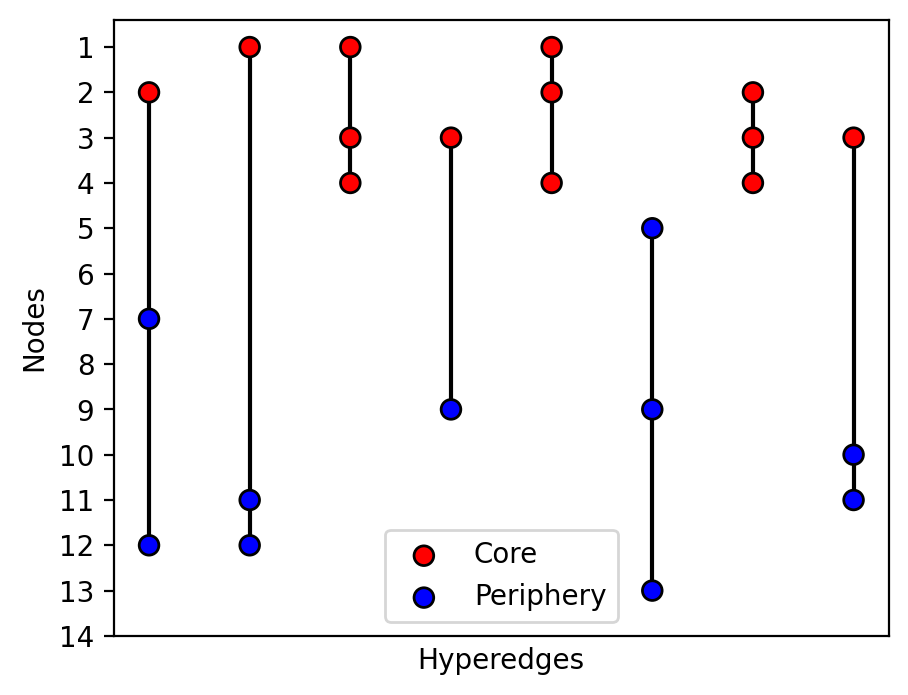

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 4
core_utils.plot_hypergraph(H, core_nodes=core_nodes)

# Centrality

In [4]:
ncent, ecent = central.nonlinear_eigenvector_centrality(H.to_numpy(), 
                                                        function='linear', 
                                                        maxiter=1000)
nodes = pd.DataFrame({
    'node' : H.index.to_list(),
    'centrality' : ncent,
})

nodes['core'] = nodes['node'].isin(core_nodes)
nodes.head()

,node,centrality,core
0,0,0.171146,True
1,1,0.164201,True
2,2,0.203486,True
3,3,0.201339,True
4,4,0.005306,False


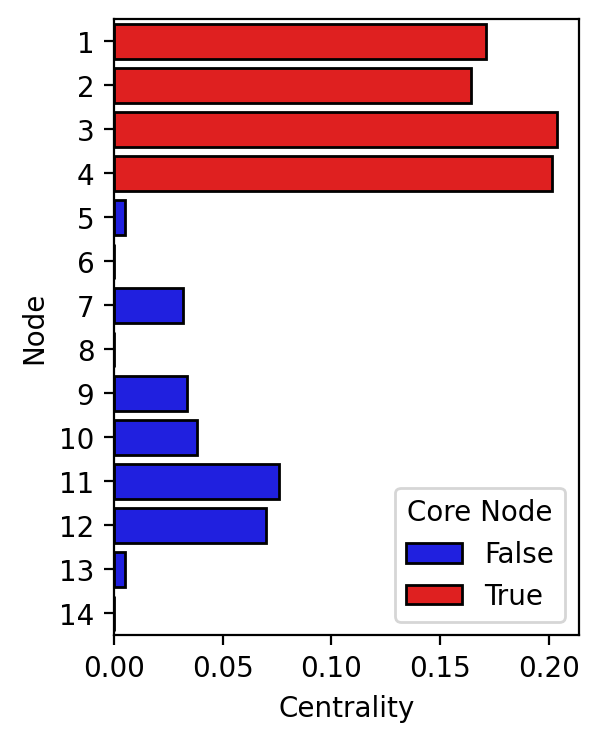

In [5]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(
    data=nodes,
    y='node',
    x='centrality',
    hue='core',
    orient='h',
    ec='k',
    palette=['b', 'r']
)

plt.yticks(H.index, H.index + 1)  # Adjust node labels if needed 
plt.ylabel('Node')
plt.xlabel('Centrality')

sns.move_legend(
    plt.gca(),
    title='Core Node',
    loc='best',
)

# clique expansion

Text(0.5, 73.44444444444441, 'Nodes')

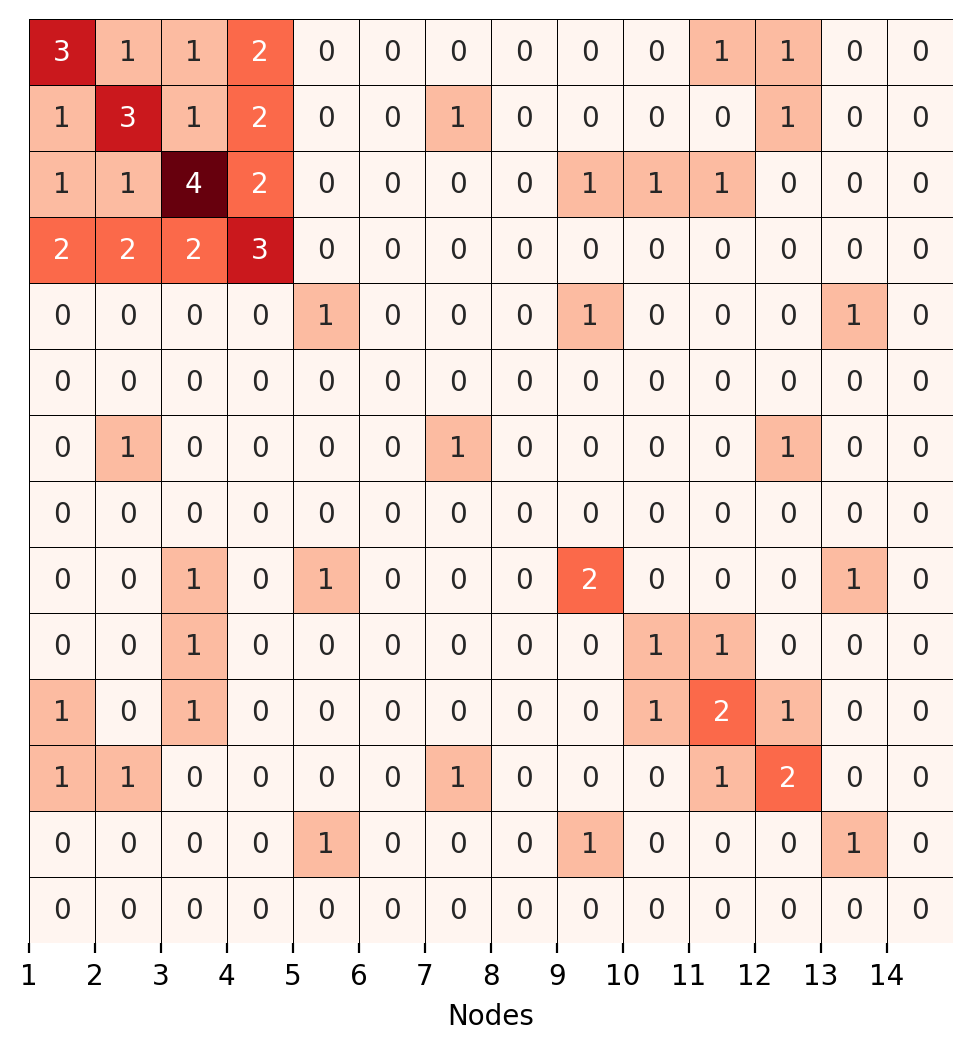

In [6]:
A = matrix.clique_expand_incidence(H, zero_diag=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(
    A,
    square=True,
    lw=0.25,
    cbar=False,
    annot=True,
    linecolor='k',
    cmap='Reds',
)

plt.yticks([])
plt.xticks(H.index, H.index + 1)
plt.xlabel('Nodes')

In [7]:
# break

# Hypergraph plotting

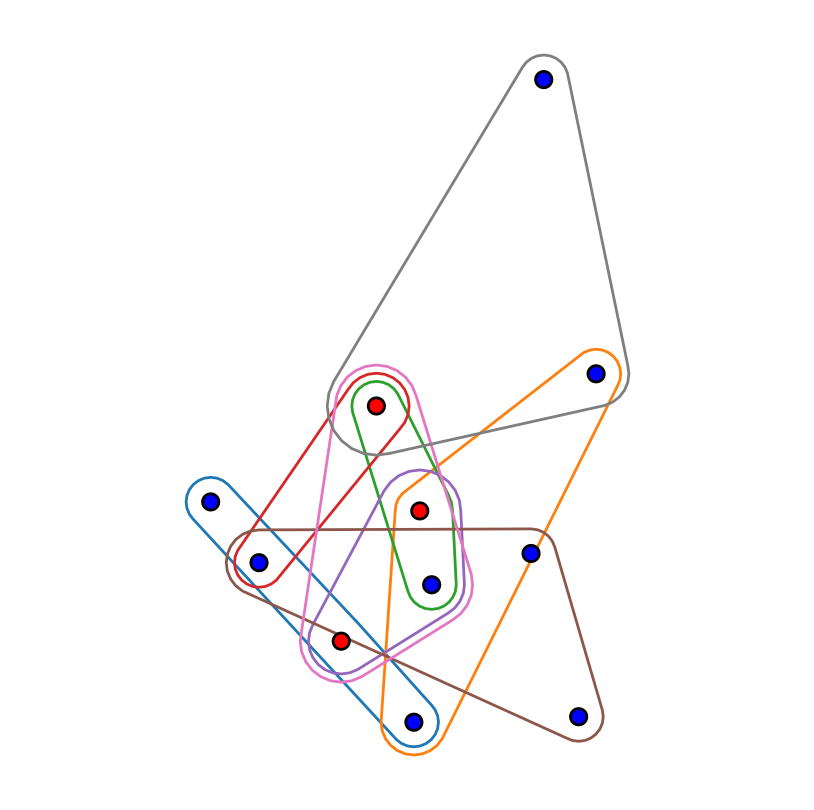

In [8]:
def to_hypernet(H):
    """A function to convert a dataframe into a 
    hypernet hypergrapgh"""
    
    iteractions = {}
    
    for idx, row in H.T.iterrows():
        iteractions[idx+1] = tuple(row[row == 1].index +1)

    hx = hnx.Hypergraph(iteractions)
    return hx
    

hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.figure(facecolor='none') 

hnx.drawing.draw(
    hx, 
    with_node_counts=False, 
    with_edge_counts=False,
    with_edge_labels=False, 
    with_node_labels=False,
    nodes_kwargs={'color' : node_color, 'edgecolor' : 'k'},
    layout_kwargs = {'seed': 39},
    # edges_kwargs={'edgecolors' : 'grey'},
)


# Compute nonlinear node centrality

In [9]:
ncent, ecent = central.nonlinear_eigenvector_centrality(
    H.to_numpy(), 
    function='linear', 
    maxiter=1000,
)

nodes = pd.DataFrame({
    'node' : H.index.to_list(),
    'centrality' : ncent,
})

nodes['core'] = nodes['node'].isin(core_nodes)

nodes = nodes.sort_values(
    by='centrality', 
    ascending=False,
)
nodes.head()

,node,centrality,core
2,2,0.203486,True
3,3,0.201339,True
0,0,0.171146,True
1,1,0.164201,True
10,10,0.075937,False


In [10]:
edges = pd.DataFrame({
    'edge' : H.columns.to_list(),
    'centrality' : ecent,
})

core_edges = np.where(H.iloc[core_nodes, :].any() == 1)[0]

edges['core'] = edges['edge'].isin(core_edges)

edges = edges.sort_values(by='centrality', 
                          ascending=False,)
edges.head(10)

,edge,centrality,core
2,2,0.201162,True
6,0,0.198736,True
4,1,0.187441,True
7,5,0.110864,False
1,4,0.110657,True
0,7,0.092823,True
3,6,0.082840,True
5,3,0.015477,True


# Plot centralities

colors.shape=(14, 4)


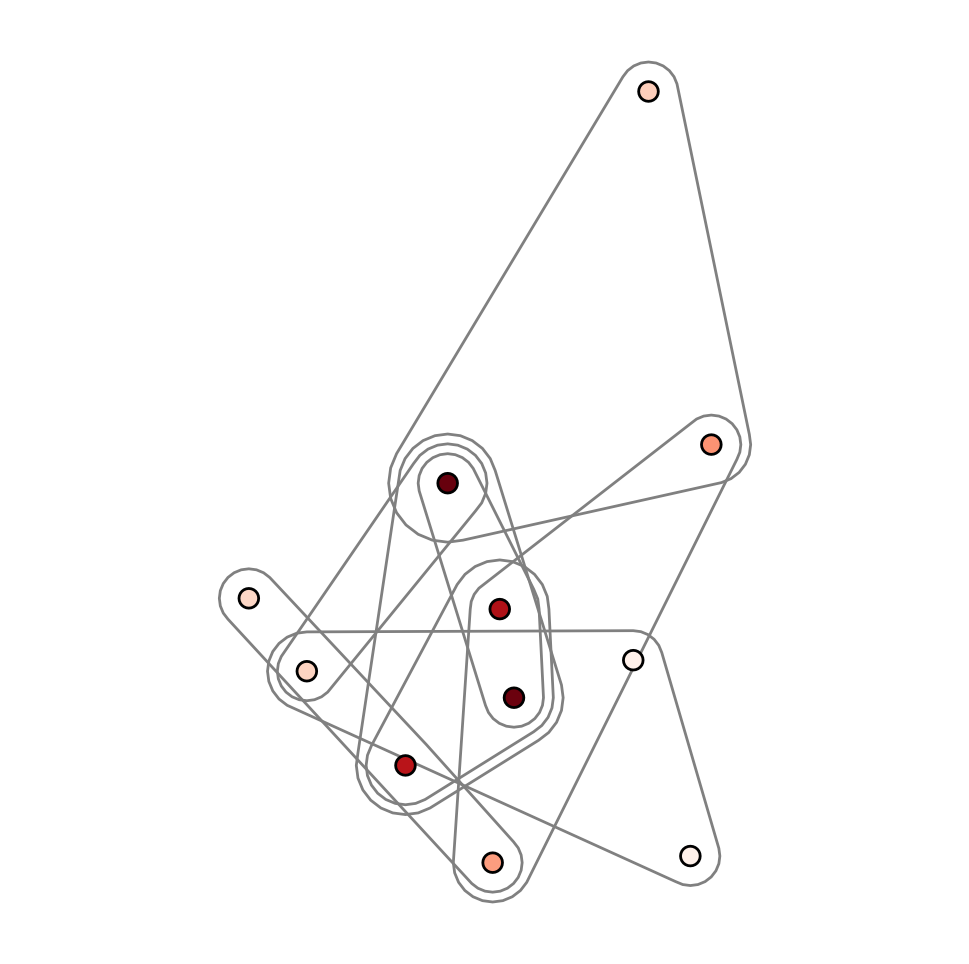

In [11]:
colors = plt2.floats_to_colors(ncent, colormap='Reds')
print(f"{colors.shape=}")

def node_color(v):
    return colors[v-1, :]


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(
    hx, 
    with_node_counts=False, 
    with_edge_counts=False,
    with_edge_labels=False, 
    with_node_labels=False,
    nodes_kwargs={'color': node_color, 'ec' : 'k'},
    edges_kwargs={'edgecolors': 'grey',},
    layout_kwargs = {'seed': 39},
)

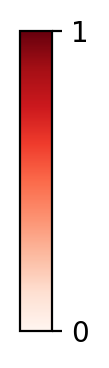

In [12]:
reload(plt2)
plt2.make_colorbar(cmap='Reds')

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# colors = plt2.floats_to_colors(ecent, colormap='viridis')

# def node_color(v):
#     if v in core_nodes:
#         return 'r'
#     else:
#         return 'b'

# def edge_color(v):
#     return colors[v, :]


# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 6, 6

# hnx.drawing.draw(hx, 
#                  with_node_counts=False, 
#                  with_edge_counts=False,
#                  with_edge_labels=False, 
#                  with_node_labels=False,
#                  nodes_kwargs={'color': node_color, 'ec' : 'k'},
#                  edges_kwargs={'edgecolors': 'k', 
#                                'linewidths' : 1, 
#                                'facecolors': edge_color, 
#                                'alpha' : 0.25},
#                  layout_kwargs = {'seed': 39},
#                 )

In [ ]:
reload(plt2)
plt2.make_colorbar()

# Is there a principaled way to "discover" this threshold?

In [ ]:
"""choosing from node centralities only"""

n_bins = 20
res = []

for n_t in np.linspace(0, 1, n_bins):
    node_idx = np.argwhere(ncent >= n_t).ravel()
    core = H.iloc[node_idx]
    
    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

                
    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None

    row = {
        'node_thresh' : n_t,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
            
    
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=res,
             x='node_thresh',
             y='fiedler_number')

max_value_row = res.loc[res['fiedler_number'].idxmax()]

plt.scatter(
    max_value_row['node_thresh'],
    max_value_row['fiedler_number'],
    c='r',
    ec='k',
    zorder=5,
)

plt.ylabel('Core Fiedler Number')
plt.xlabel('Node Centrality Threshold')

# Archive 

In [ ]:
break

# sparse hypergraph with core periphery structure

In [ ]:

# Example usage
num_core_nodes = 3
num_periphery_nodes = 15
edge_probability_periphery = 0.1
avg_edge_size = 3
core_periphery_probability = 0.25

core_nodes, periphery_nodes, edges, incidence_matrix = generate_core_periphery_hypergraph(
    num_core_nodes, num_periphery_nodes, edge_probability_core, 
    edge_probability_periphery, avg_edge_size, core_periphery_probability)

H = pd.DataFrame(incidence_matrix)
print(f"{H.shape=}")
H.head()

In [ ]:
hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'
    
    
px = 0.2
    
def edge_color(v):
    rand = np.random.random()
    if rand > px:
        return 'none'
    else:
        return 'grey'
    
        

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(
    hx, 
    with_node_counts=False, 
    with_edge_counts=False,
    with_edge_labels=False, 
    with_node_labels=False,
    nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
    edges_kwargs={
     'edgecolors': 'k', 
     'lw' : 1, 
     'facecolors': edge_color, 
     'alpha' : 0.15,
    },
    layout_kwargs = {'seed': 39},
                )

In [ ]:
hx = to_hypernet(H)

def node_color(v):
    if v in core_nodes:
        return 'r'
    else:
        return 'b'
    
    
px = 0.2
    
def edge_color(v):
    rand = np.random.random()
    if rand > px:
        return 'none'
    else:
        return 'grey'
    
        

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

hnx.drawing.draw(hx, 
                 with_node_counts=False, 
                 with_edge_counts=False,
                 with_edge_labels=False, 
                 with_node_labels=False,
                 nodes_kwargs={'color': node_color, 'edgecolor' : 'k'},
                 edges_kwargs={
                     'edgecolors': edge_color, 
                     'lw' : 1, 
                 },
                 layout_kwargs = {'seed': 39},
                )

In [ ]:
break

In [ ]:
"""Choosing from both thresholds """

print(f"{H.shape=}")

res = []

for n_t in ncent:
    node_idx = np.argwhere(ncent >= n_t).ravel()
    
    for e_t in ecent:
        edge_idx = np.argwhere(ecent >= e_t).ravel()
        core = H.iloc[node_idx][edge_idx]
        
        if core.empty:
            continue
        
        try:
            L = matrix.normalized_hypergraph_laplacian(core).todense()        
            eigenvalues, eigenvectors = np.linalg.eigh(L)
            fiedler_number = eigenvalues[1]
        except:
            fiedler_number = None
        
        row = {
            'node_thresh' : n_t,
            'edge_thresh' : e_t,
            'n_nodes' : len(node_idx),
            'n_edges' : len(edge_idx),
            'core_nodes' : node_idx,
            'core_edges' : edge_idx,
            'fiedler_number' : fiedler_number,
        }
        res.append(row)
        
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head()

In [ ]:
res[(res['n_nodes'] == 4) & (res['n_edges'] == 3)]

In [ ]:
res[(res['node_thresh'] > 0.102)  & (res['edge_thresh'] > 0.147)]

In [ ]:
break

# Archive

In [ ]:
# def plot_core_periphery_networkx(core_nodes, periphery_nodes, edges):
#     """
#     This function plots a core-periphery network using NetworkX for layout and Matplotlib for visualization.

#     Args:
#       core_nodes: List of core nodes.
#       periphery_nodes: List of periphery nodes.
#       edges: List of lists, where each inner list represents an edge in the hypergraph.
#     """
#     plt.figure(figsize=(8, 6))

#     # Create a NetworkX graph
#     G = nx.Graph()

#     # Add nodes with color distinction for core and periphery
#     G.add_nodes_from(core_nodes, color='red')
#     G.add_nodes_from(periphery_nodes, color='blue')

#     # Add edges
#     for edge in edges:
#         for i in range(len(edge) - 1):
#             G.add_edge(edge[i], edge[i + 1])

#     # Use a layout algorithm for node positioning (adjust as needed)
#     pos = nx.spring_layout(G)

#     # Draw the graph with node colors and positions
#     nx.draw_networkx_nodes(G, pos, nodelist=periphery_nodes, node_color='blue', node_size=150, edgecolors='k')
#     nx.draw_networkx_nodes(G, pos, nodelist=core_nodes, node_color='red', node_size=350, edgecolors='k')
#     nx.draw_networkx_edges(G, pos, alpha=0.7, width=1.5)

#     # Labels and title
#     plt.axis('off')
#     plt.show()
    
# plt.rcParams['figure.dpi'] = 200
# plot_core_periphery_networkx(core_nodes, periphery_nodes, edges)

In [ ]:
break